# EuroSAT Dataset Applying Custom CNN 

In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [2]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [3]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [4]:
data_dir = "/kaggle/input/eurosat-dataset/EuroSAT"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame(
    {
        "file_path": file_paths,
        "label": labels,
        }
    )
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: SeaLake --> count: 3000
class: HerbaceousVegetation --> count: 3000
class: Forest --> count: 3000
class: AnnualCrop --> count: 3000
class: Residential --> count: 3000
class: Highway --> count: 2500
class: Industrial --> count: 2500
class: PermanentCrop --> count: 2500
class: River --> count: 2500
class: Pasture --> count: 2000


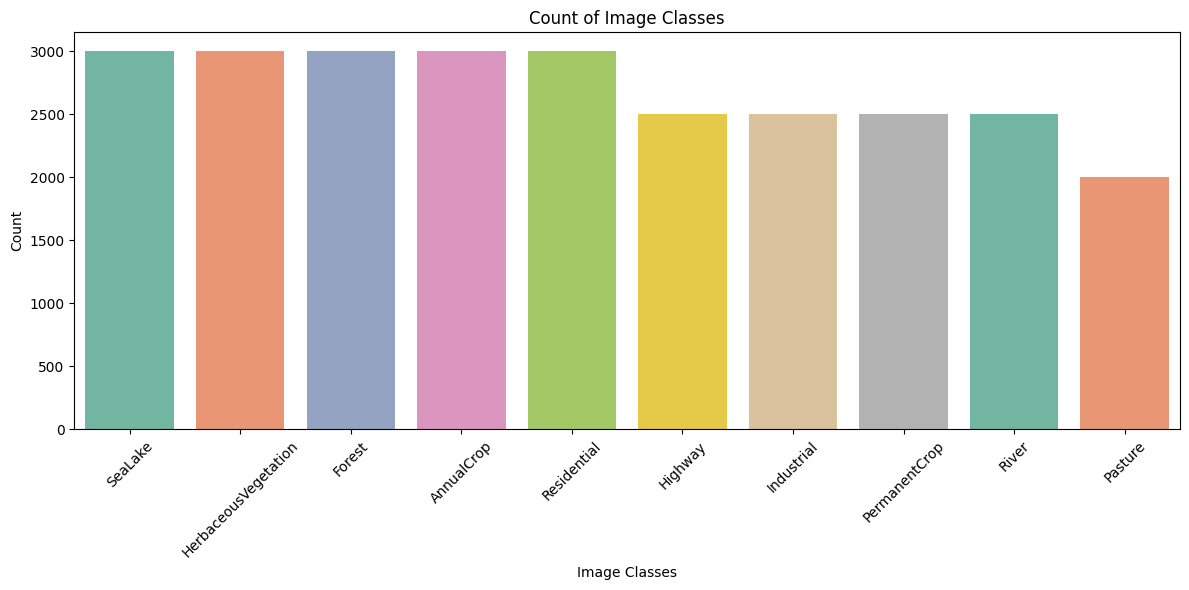

In [5]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

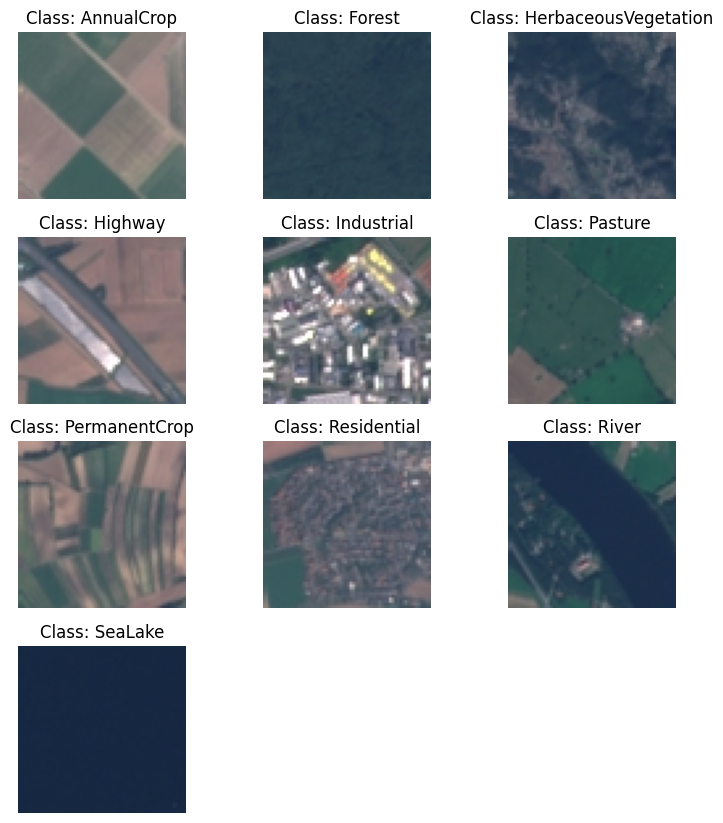

In [6]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue


plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [7]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30,
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50,
                                            stratify=temp_dataframe['label'], random_state=42)

In [8]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18900
Validation Data:  4050
Test Data:  4050
-------------------------------------------
Total amounts of data in the dataset:  27000


In [9]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                   Count
--------------------  -------
Residential              2100
SeaLake                  2100
AnnualCrop               2100
Forest                   2100
HerbaceousVegetation     2100
PermanentCrop            1750
Industrial               1750
Highway                  1750
River                    1750
Pasture                  1400

Validation Dataset
Class                   Count
--------------------  -------
AnnualCrop                450
SeaLake                   450
Residential               450
HerbaceousVegetation      450
Forest                    450
Highway                   375
Industrial                375
PermanentCrop             375
River                     375
Pasture                   300

Test Dataset
Class                   Count
--------------------  -------
SeaLake                   450
AnnualCrop                450
Forest                    450
HerbaceousVegetation      450
Residential               450
PermanentCrop         

label mapping

In [10]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


### Device Variable

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [12]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Integrate Class-weight Loss

In [13]:
# Extract class labels from your training dataframe
train_labels = train_dataframe['label'].map(label_map).values
num_classes = len(classes)

# print(np.unique(train_labels))
# print(np.arange(num_classes))

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Dataset Class, Dataloader and Transform

In [14]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.classes = sorted(dataframe['label'].unique())
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)



In [15]:
train_batch = 64
val_batch = 8

def data_transfrom():
    size = 224
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])

    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])


    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=4)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=4)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=4)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Convolutional Neural Netwirk (G7CNN)

In [16]:

class G7CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(G7CNN, self).__init__()

        self.conv_block = nn.Sequential(
            # Input: 3 x 224 x 224

            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # → 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # → 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),

            nn.MaxPool2d(2),  # → 32 x 112 x 112

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # → 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # → 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),

            nn.MaxPool2d(2),  # → 64 x 56 x 56

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # → 128 x 56 x 56
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # → 128 x 56 x 56
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),

            nn.MaxPool2d(2),  # → 128 x 28 x 28

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # → 256 x 28 x 28
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # → 256 x 28 x 28
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),

            nn.MaxPool2d(2),  # → 256 x 14 x 14

            # Block 5
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # → 512 x 14 x 14
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),  # → 512 x 14 x 14
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),

            nn.MaxPool2d(2)  # → 512 x 7 x 7
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # → 512 x 1 x 1

        self.classifier = nn.Sequential(
            nn.Flatten(),                        # → 512
            nn.Linear(512, 512),                 # → 512
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)          # → num_classes
        )

    def forward(self, x):
        x = self.conv_block(x)     # → 512 x 7 x 7
        x = self.global_pool(x)    # → 512 x 1 x 1
        x = self.classifier(x)     # → num_classes
        return x


In [17]:
total_class = 10
learning_rate = 0.0001

model = G7CNN(num_classes=total_class)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         LeakyReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
         LeakyReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
       BatchNorm2d-9         [-1, 64, 112, 112]             128
        LeakyReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,928
      BatchNorm2d-12         [-1, 64, 112, 112]             128
        LeakyReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

### Training

In [18]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=50, early_stop_patience=15, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"✅ Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"⏹️ Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model,
    criterion,
    optimizer,
    dataloader_train_dataset,
    dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/50: 100%|██████████| 296/296 [01:07<00:00,  4.41it/s, acc=0.63, loss=1.09] 

Training Loss: 1.094 Acc: 0.630


Validation Loss: 0.629 Acc: 0.787
✅ Best model saved at epoch 1 with validation accuracy: 0.787


Epoch 2/50: 100%|██████████| 296/296 [01:06<00:00,  4.42it/s, acc=0.77, loss=0.692] 

Training Loss: 0.692 Acc: 0.770


Validation Loss: 0.557 Acc: 0.805
✅ Best model saved at epoch 2 with validation accuracy: 0.805


Epoch 3/50: 100%|██████████| 296/296 [01:06<00:00,  4.43it/s, acc=0.827, loss=0.514]

Training Loss: 0.514 Acc: 0.827


Validation Loss: 0.521 Acc: 0.812
✅ Best model saved at epoch 3 with validation accuracy: 0.812


Epoch 4/50: 100%|██████████| 296/296 [01:06<00:00,  4.42it/s, acc=0.869, loss=0.404]

Training Loss: 0.404 Acc: 0.869


Validation Loss: 0.297 Acc: 0.902
✅ Best model saved at epoch 4 with validation accuracy: 0.902


Epoch 5/50: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.892, loss=0.332]

Training Loss: 0.332 Acc: 0.892


Validation Loss: 0.246 Acc: 0.914
✅ Best model saved at epoch 5 with validation accuracy: 0.914


Epoch 6/50: 100%|██████████| 296/296 [01:06<00:00,  4.42it/s, acc=0.903, loss=0.298]

Training Loss: 0.298 Acc: 0.903


Validation Loss: 0.489 Acc: 0.846


Epoch 7/50: 100%|██████████| 296/296 [01:06<00:00,  4.43it/s, acc=0.911, loss=0.273]

Training Loss: 0.273 Acc: 0.911


Validation Loss: 0.223 Acc: 0.925
✅ Best model saved at epoch 7 with validation accuracy: 0.925


Epoch 8/50: 100%|██████████| 296/296 [01:07<00:00,  4.40it/s, acc=0.918, loss=0.248]

Training Loss: 0.248 Acc: 0.918


Validation Loss: 0.245 Acc: 0.916


Epoch 9/50: 100%|██████████| 296/296 [01:06<00:00,  4.43it/s, acc=0.924, loss=0.225]

Training Loss: 0.225 Acc: 0.924


Validation Loss: 0.300 Acc: 0.904


Epoch 10/50: 100%|██████████| 296/296 [01:07<00:00,  4.41it/s, acc=0.927, loss=0.214]

Training Loss: 0.214 Acc: 0.927


Validation Loss: 0.191 Acc: 0.939
✅ Best model saved at epoch 10 with validation accuracy: 0.939


Epoch 11/50: 100%|██████████| 296/296 [01:06<00:00,  4.42it/s, acc=0.932, loss=0.199]

Training Loss: 0.199 Acc: 0.932


Validation Loss: 0.210 Acc: 0.933


Epoch 12/50: 100%|██████████| 296/296 [01:06<00:00,  4.42it/s, acc=0.934, loss=0.19] 

Training Loss: 0.190 Acc: 0.934


Validation Loss: 0.181 Acc: 0.938


Epoch 13/50: 100%|██████████| 296/296 [01:07<00:00,  4.41it/s, acc=0.937, loss=0.185]

Training Loss: 0.185 Acc: 0.937


Validation Loss: 0.199 Acc: 0.934


Epoch 14/50: 100%|██████████| 296/296 [01:06<00:00,  4.43it/s, acc=0.942, loss=0.171]

Training Loss: 0.171 Acc: 0.942


Validation Loss: 0.137 Acc: 0.952
✅ Best model saved at epoch 14 with validation accuracy: 0.952


Epoch 15/50: 100%|██████████| 296/296 [01:07<00:00,  4.41it/s, acc=0.944, loss=0.171]

Training Loss: 0.171 Acc: 0.944


Validation Loss: 0.203 Acc: 0.931


Epoch 16/50: 100%|██████████| 296/296 [01:06<00:00,  4.42it/s, acc=0.944, loss=0.163]

Training Loss: 0.163 Acc: 0.944


Validation Loss: 0.174 Acc: 0.941


Epoch 17/50: 100%|██████████| 296/296 [01:07<00:00,  4.41it/s, acc=0.946, loss=0.156]

Training Loss: 0.156 Acc: 0.946


Validation Loss: 0.151 Acc: 0.948


Epoch 18/50: 100%|██████████| 296/296 [01:07<00:00,  4.42it/s, acc=0.952, loss=0.143]

Training Loss: 0.143 Acc: 0.952


Validation Loss: 0.127 Acc: 0.955
✅ Best model saved at epoch 18 with validation accuracy: 0.955


Epoch 19/50: 100%|██████████| 296/296 [01:06<00:00,  4.43it/s, acc=0.949, loss=0.151]

Training Loss: 0.151 Acc: 0.949


Validation Loss: 0.131 Acc: 0.958
✅ Best model saved at epoch 19 with validation accuracy: 0.958


Epoch 20/50: 100%|██████████| 296/296 [01:07<00:00,  4.41it/s, acc=0.952, loss=0.141]

Training Loss: 0.141 Acc: 0.952


Validation Loss: 0.150 Acc: 0.950


Epoch 21/50: 100%|██████████| 296/296 [01:06<00:00,  4.42it/s, acc=0.953, loss=0.139]

Training Loss: 0.139 Acc: 0.953


Validation Loss: 0.164 Acc: 0.953


Epoch 22/50: 100%|██████████| 296/296 [01:07<00:00,  4.40it/s, acc=0.955, loss=0.13] 

Training Loss: 0.130 Acc: 0.955


Validation Loss: 0.108 Acc: 0.963
✅ Best model saved at epoch 22 with validation accuracy: 0.963


Epoch 23/50: 100%|██████████| 296/296 [01:07<00:00,  4.40it/s, acc=0.955, loss=0.129]

Training Loss: 0.129 Acc: 0.955


Validation Loss: 0.172 Acc: 0.941


Epoch 24/50: 100%|██████████| 296/296 [01:07<00:00,  4.40it/s, acc=0.956, loss=0.129]

Training Loss: 0.129 Acc: 0.956


Validation Loss: 0.160 Acc: 0.949


Epoch 25/50: 100%|██████████| 296/296 [01:06<00:00,  4.42it/s, acc=0.957, loss=0.12] 

Training Loss: 0.120 Acc: 0.957


Validation Loss: 0.115 Acc: 0.962


Epoch 26/50: 100%|██████████| 296/296 [01:06<00:00,  4.42it/s, acc=0.956, loss=0.13] 

Training Loss: 0.130 Acc: 0.956


Validation Loss: 0.119 Acc: 0.959


Epoch 27/50: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.961, loss=0.116]

Training Loss: 0.116 Acc: 0.961


Validation Loss: 0.144 Acc: 0.953


Epoch 28/50: 100%|██████████| 296/296 [01:07<00:00,  4.40it/s, acc=0.961, loss=0.114]

Training Loss: 0.114 Acc: 0.961


Validation Loss: 0.129 Acc: 0.959


Epoch 29/50: 100%|██████████| 296/296 [01:07<00:00,  4.40it/s, acc=0.961, loss=0.111]

Training Loss: 0.111 Acc: 0.961


Validation Loss: 0.098 Acc: 0.968
✅ Best model saved at epoch 29 with validation accuracy: 0.968


Epoch 30/50: 100%|██████████| 296/296 [01:07<00:00,  4.42it/s, acc=0.962, loss=0.111]

Training Loss: 0.111 Acc: 0.962


Validation Loss: 0.141 Acc: 0.956


Epoch 31/50: 100%|██████████| 296/296 [01:07<00:00,  4.40it/s, acc=0.964, loss=0.106]

Training Loss: 0.106 Acc: 0.964


Validation Loss: 0.134 Acc: 0.960


Epoch 32/50: 100%|██████████| 296/296 [01:07<00:00,  4.41it/s, acc=0.962, loss=0.109] 

Training Loss: 0.109 Acc: 0.962


Validation Loss: 0.106 Acc: 0.962


Epoch 33/50: 100%|██████████| 296/296 [01:07<00:00,  4.41it/s, acc=0.963, loss=0.105]

Training Loss: 0.105 Acc: 0.963


Validation Loss: 0.131 Acc: 0.958


Epoch 34/50: 100%|██████████| 296/296 [01:06<00:00,  4.43it/s, acc=0.966, loss=0.101] 

Training Loss: 0.101 Acc: 0.966


Validation Loss: 0.153 Acc: 0.951


Epoch 35/50: 100%|██████████| 296/296 [01:06<00:00,  4.43it/s, acc=0.962, loss=0.105] 

Training Loss: 0.105 Acc: 0.962


Validation Loss: 0.092 Acc: 0.970
✅ Best model saved at epoch 35 with validation accuracy: 0.970


Epoch 36/50: 100%|██████████| 296/296 [01:06<00:00,  4.43it/s, acc=0.965, loss=0.0993]

Training Loss: 0.099 Acc: 0.965


Validation Loss: 0.109 Acc: 0.962


Epoch 37/50: 100%|██████████| 296/296 [01:07<00:00,  4.40it/s, acc=0.969, loss=0.0911]

Training Loss: 0.091 Acc: 0.969


Validation Loss: 0.124 Acc: 0.963


Epoch 38/50: 100%|██████████| 296/296 [01:07<00:00,  4.41it/s, acc=0.967, loss=0.0941]

Training Loss: 0.094 Acc: 0.967


Validation Loss: 0.109 Acc: 0.968


Epoch 39/50: 100%|██████████| 296/296 [01:06<00:00,  4.43it/s, acc=0.969, loss=0.0906]

Training Loss: 0.091 Acc: 0.969


Validation Loss: 0.147 Acc: 0.953


Epoch 40/50: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.967, loss=0.0912]

Training Loss: 0.091 Acc: 0.967


Validation Loss: 0.097 Acc: 0.973
✅ Best model saved at epoch 40 with validation accuracy: 0.973


Epoch 41/50: 100%|██████████| 296/296 [01:06<00:00,  4.43it/s, acc=0.969, loss=0.0884]

Training Loss: 0.088 Acc: 0.969


Validation Loss: 0.123 Acc: 0.962


Epoch 42/50: 100%|██████████| 296/296 [01:06<00:00,  4.42it/s, acc=0.968, loss=0.0914]

Training Loss: 0.091 Acc: 0.968


Validation Loss: 0.209 Acc: 0.934


Epoch 43/50: 100%|██████████| 296/296 [01:06<00:00,  4.42it/s, acc=0.97, loss=0.0862] 

Training Loss: 0.086 Acc: 0.970


Validation Loss: 0.090 Acc: 0.972


Epoch 44/50: 100%|██████████| 296/296 [01:07<00:00,  4.41it/s, acc=0.972, loss=0.0833]

Training Loss: 0.083 Acc: 0.972


Validation Loss: 0.082 Acc: 0.972


Epoch 45/50: 100%|██████████| 296/296 [01:07<00:00,  4.40it/s, acc=0.971, loss=0.0876]

Training Loss: 0.088 Acc: 0.971


Validation Loss: 0.134 Acc: 0.961


Epoch 46/50: 100%|██████████| 296/296 [01:07<00:00,  4.42it/s, acc=0.97, loss=0.0871] 

Training Loss: 0.087 Acc: 0.970


Validation Loss: 0.131 Acc: 0.959


Epoch 47/50: 100%|██████████| 296/296 [01:07<00:00,  4.41it/s, acc=0.972, loss=0.0823]

Training Loss: 0.082 Acc: 0.972


Validation Loss: 0.127 Acc: 0.958


Epoch 48/50: 100%|██████████| 296/296 [01:06<00:00,  4.44it/s, acc=0.973, loss=0.0785]

Training Loss: 0.079 Acc: 0.973


Validation Loss: 0.100 Acc: 0.968


Epoch 49/50: 100%|██████████| 296/296 [01:07<00:00,  4.41it/s, acc=0.973, loss=0.0784]

Training Loss: 0.078 Acc: 0.973


Validation Loss: 0.093 Acc: 0.972


Epoch 50/50: 100%|██████████| 296/296 [01:06<00:00,  4.42it/s, acc=0.973, loss=0.0829]

Training Loss: 0.083 Acc: 0.973


Validation Loss: 0.104 Acc: 0.968
Training Time: 3702.56 seconds ---> 61.71 minutes


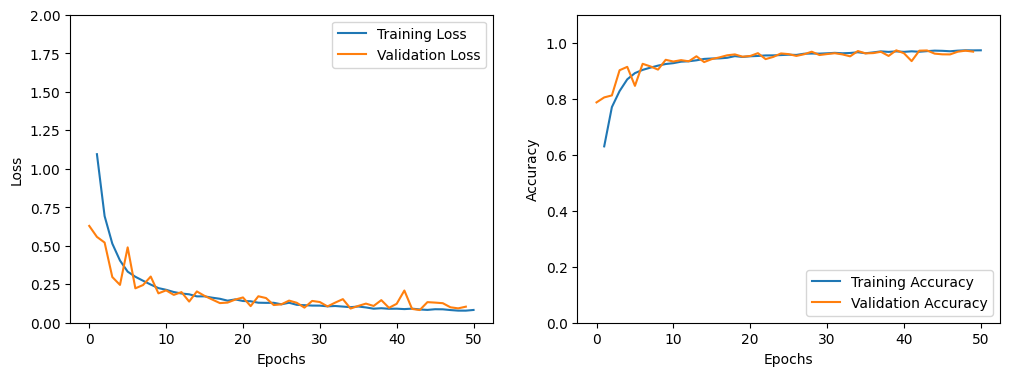

In [19]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [20]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 40) - Validation Loss: 0.093, Validation Accuracy: 0.972


In [21]:

start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.968
Test Time: 20.32 seconds ---> 0.34 minutes


In [22]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       450
           1       0.99      0.98      0.99       450
           2       0.94      0.97      0.95       450
           3       0.96      0.99      0.97       375
           4       0.98      0.99      0.99       375
           5       0.97      0.95      0.96       300
           6       0.94      0.93      0.93       375
           7       0.99      0.99      0.99       450
           8       0.97      0.95      0.96       375
           9       1.00      0.98      0.99       450

    accuracy                           0.97      4050
   macro avg       0.97      0.97      0.97      4050
weighted avg       0.97      0.97      0.97      4050

Class 0 Accuracy: 0.967
Class 1 Accuracy: 0.987
Class 2 Accuracy: 0.967
Class 3 Accuracy: 0.981
Class 4 Accuracy: 0.992
Class 5 Accuracy: 0.940
Class 6 Accuracy: 0.944
Class 7 Accuracy: 0.989
Class 8 Accuracy: 0.936
Cl

### Confusion Matrix

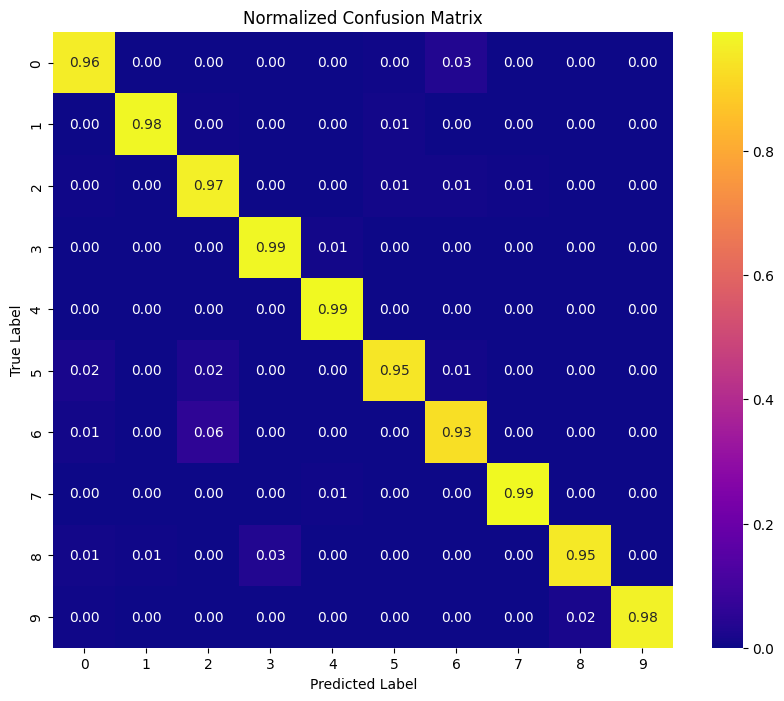

In [26]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


### AUC, ROC Curve

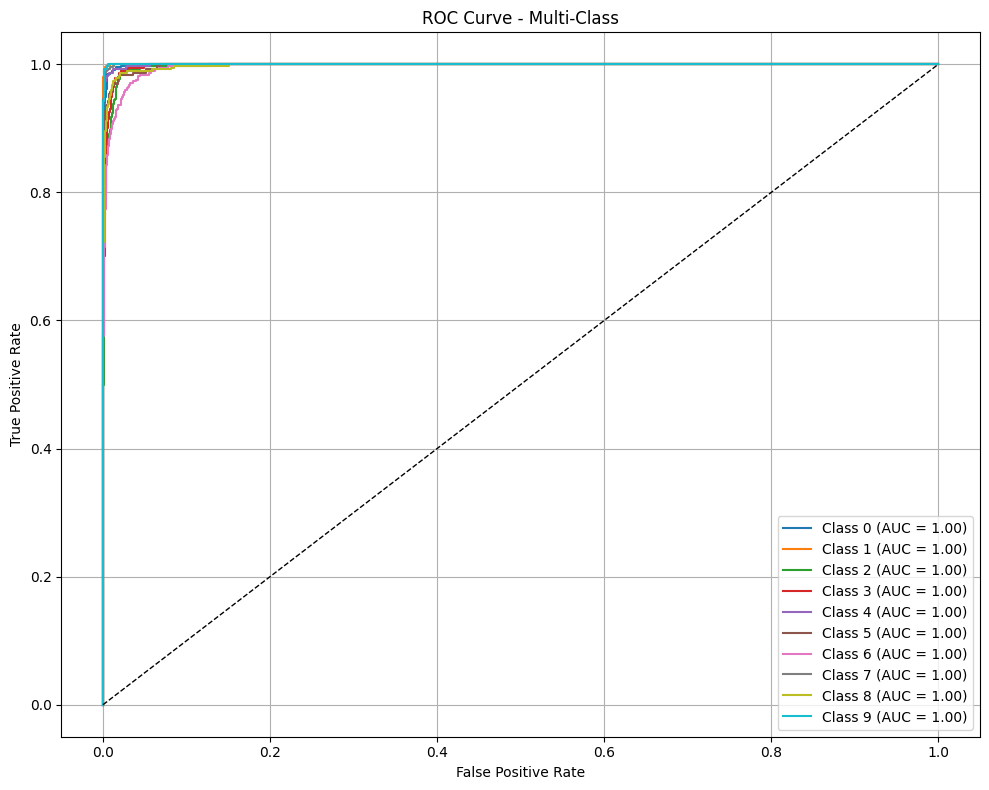

In [27]:
# Binarize labels
y_true_bin = label_binarize(y_true, classes=list(range(total_class)))

# Compute ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(total_class):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(total_class):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()